# Analyze and map liquor data

In [1]:
# standard initialization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime, timedelta
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import geocoder
import geoplot
import itertools
from sklearn.decomposition import FastICA, PCA

# set constants
main_path = '/Users/rita/Dropbox/InsightDataScience/Project'
api_key = open(main_path + '/config.py', 'r')
api_key = api_key.read().replace('api_key = ', '').replace('“','').replace('”','')

In [2]:
df_1_by_wkday = pd.read_csv(main_path + '/Results/df_by_wkday.csv')
df_1_by_wkday_type = pd.read_csv(main_path + '/Results/df_by_wkday_type.csv')
dist_mat = pd.read_csv(main_path + '/Results/dist_block_to_station.csv', header=None)
dist_mat = dist_mat.values
nyc_subway_trnstl_template = pd.read_csv(main_path + '/Results/subway_station_info.csv')
nyc_blk_map = gpd.read_file(main_path + '/Results/nyc_blk_map.shp')
nyc_blk_map['Area'] = nyc_blk_map.area

In [3]:
# sort dfs to match how they appear in dist_mat
# otherwise the spatial mapping will be messed up
sorter = nyc_subway_trnstl_template.STATION

df_1_by_wkday.STATION = df_1_by_wkday.STATION.astype("category")
df_1_by_wkday.STATION.cat.set_categories(sorter, inplace=True)
df_1_by_wkday = df_1_by_wkday.sort_values(['STATION', 'WK_DAY', 'TIME' ])

df_1_by_wkday_type.STATION = df_1_by_wkday_type.STATION.astype("category")
df_1_by_wkday_type.STATION.cat.set_categories(sorter, inplace=True)
df_1_by_wkday_type = df_1_by_wkday_type.sort_values(['STATION', 'WK_DAY_TYPE', 'TIME' ])

In [4]:
# get map of neighborhoods
nyc_nbhd_map = gpd.read_file(main_path + '/Data/Locations/ZillowNeighborhoods-NY/ZillowNeighborhoods-NY.shp')
nyc_nbhd_map = nyc_nbhd_map[nyc_nbhd_map.County.isin(['Kings', 
                                                        'Queens', 'Bronx', 'Richmond'])]
nyc_nbhd_map = nyc_nbhd_map.reset_index() # need to do this
nyc_nbhd_map.rename({'Name': 'Neighborhood'}, axis='columns', inplace=True)
nyc_nbhd_map = nyc_nbhd_map[['Neighborhood', 'geometry']]
nyc_nbhd_map.crs = nyc_blk_map.crs # set to the same coord system
nyc_nbhd_map.to_file(main_path + '/Results/nyc_nbhd_map.shp') # save for front end

# get all boroughs
nyc_borough_map = gpd.read_file(main_path + '/Data/Locations/Boroughs/geo_export_042a7af9-2558-430b-b512-5799557e5b47.shp')

# make geopandas map of subway trnstl
nyc_subway_trnstl_template['geometry'] = nyc_subway_trnstl_template.apply(lambda row: 
                                                  Point(row['GTFS Longitude'], row['GTFS Latitude']), axis=1)
nyc_subway_trnstl_map = gpd.GeoDataFrame(nyc_subway_trnstl_template, geometry='geometry', crs=nyc_nbhd_map.crs)

/Users/rita/anaconda3/envs/insight/lib/python3.7/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [5]:
# spherical distance
# Taken from here: 
# https://community.esri.com/groups/coordinate-reference-systems/blog/2017/10/05/haversine-formula
def haversine(coord1: object, coord2: object):
    import math

    # Coordinates in decimal degrees (e.g. 2.89078, 12.79797)
    lon1, lat1 = coord1
    lon2, lat2 = coord2

    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    meters = R * c  # output distance in meters
    km = meters / 1000.0  # output distance in kilometers

    meters = round(meters, 3)
    km = round(km, 3)
    miles = round(meters/1609.34,3)
    
    return miles
    #print(f"Distance: {meters} m")
    #print(f"Distance: {km} km")

In [6]:
from shapely.geometry import Polygon
# get plot dimensions

max_long = np.amax(nyc_borough_map.geometry.bounds).maxx
max_lat = np.amax(nyc_borough_map.geometry.bounds).maxy
min_long = np.amin(nyc_borough_map.geometry.bounds).minx
min_lat = np.amin(nyc_borough_map.geometry.bounds).miny

x_size = haversine([min_long, min_lat], [max_long, min_lat])/2
y_size = haversine([min_long, min_lat], [min_long, max_lat])/2

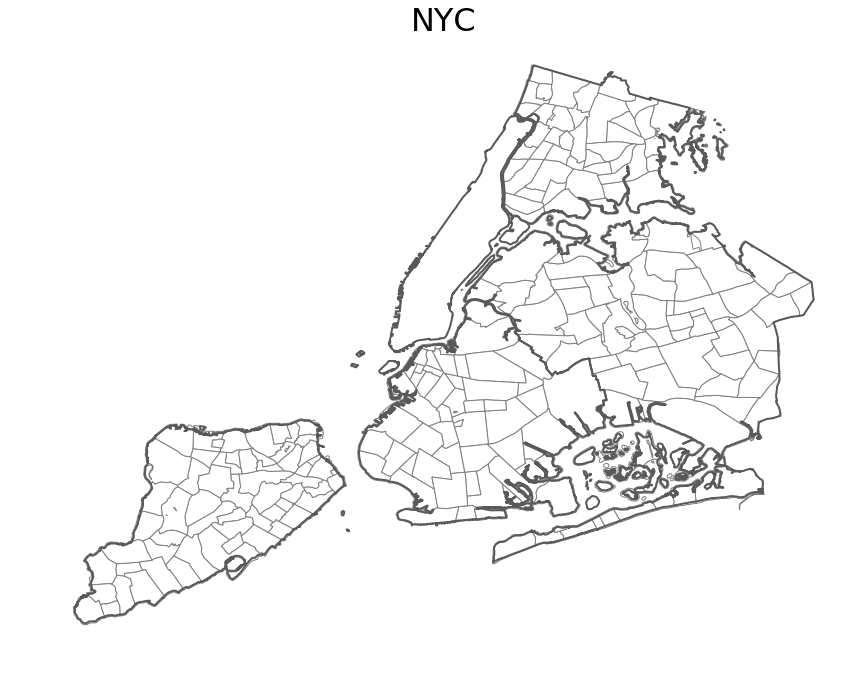

In [7]:
# Plot NYC

fig, ax = plt.subplots(1, figsize=(x_size, y_size))
nyc_nbhd_map.plot(ax=ax, color='white', edgecolor='gray')
nyc_borough_map.plot(ax=ax, color='none', edgecolor='0.35', linewidth=2)
ax.axis('off') # remove the axis
ax.set_title("NYC", fontdict={'fontsize': '32', 'fontweight': '5'}) # add a title
fig.savefig(main_path + '/Results/Pics/Maps/nyc.png', dpi=500) 
plt.show()

## Liquor data

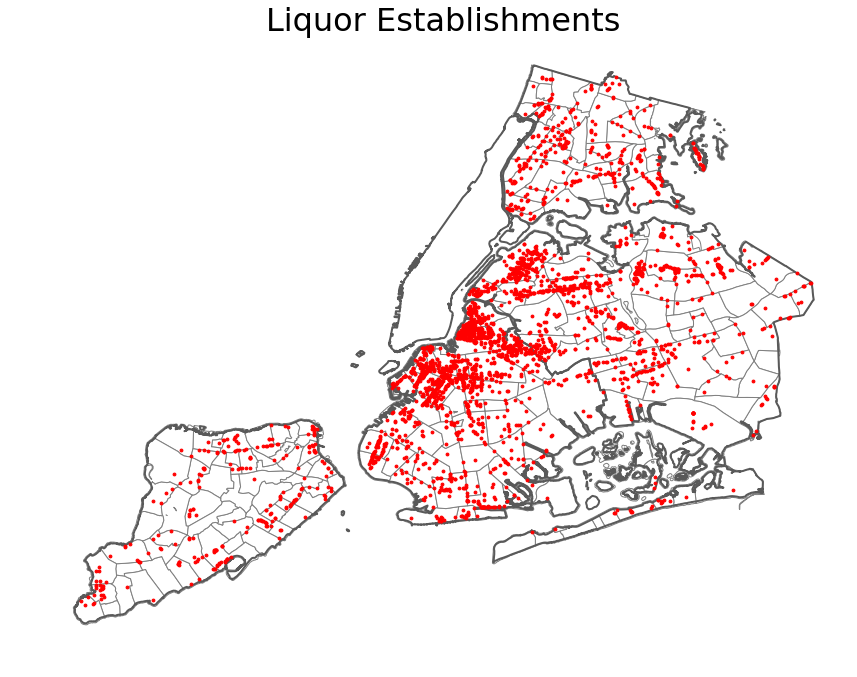

In [8]:
# get liquor license data
liquor_df = pd.read_csv(main_path + '/Data/Liquor/Liquor_Authority_Quarterly_List_of_Active_Licenses.csv', 
                        low_memory=False)

# limit to outer boroughs
liquor_df = liquor_df[liquor_df['County Name (Licensee)'].isin(['KINGS', 
                                                        'QUEENS', 'BRONX', 'RICHMOND'])]

# get columns of interest
liquor_df = liquor_df[['License Type Name', 'Premises Name', 'Latitude', 'Longitude']]
liquor_df = liquor_df.rename(columns={'License Type Name': 'LicenseType', 'Premises Name': 'PremisesName'})

# get places with liquor licenses that suggest they are bars/restaurants
licenses_of_interest = ['CABARET LIQUOR', 'CLUB LIQUOR', 'CLUB WINE', 'ON-PREMISES LIQUOR', 
                        'SUMMER CLUB LIQUOR', 'SUMMER EATING PLACE BEER', 'SUMMER O.P. FOOD & BEV', 
                        'SUMMER RESTAURANT WINE', 'SUMMER TAVERN WINE',
                        'SUMMER VESSEL LIQUOR', 'TAVERN WINE', 'VESSEL LIQUOR']
liquor_df = liquor_df[liquor_df.LicenseType.isin(licenses_of_interest)]

# remove nans
liquor_df = liquor_df.dropna()

# aggregate by premise name since some places hold more than one license
liquor_df = liquor_df.groupby('PremisesName').agg(
                            {'Latitude': 'mean', 
                             'Longitude':'mean', 
                             'LicenseType': lambda x: ', '.join(x)})

# make a geometry column
liquor_df['geometry'] = liquor_df.apply(lambda row: 
                                        Point(row['Longitude'], row['Latitude']), axis=1)

# Plot points
liquor_map = gpd.GeoDataFrame(liquor_df, crs=nyc_blk_map.crs)

# do a spatial join with bklyn blocks to remove points w/bad coords
liquor_map = gpd.tools.sjoin(liquor_map, nyc_blk_map, 
                                   how='left')
liquor_map = liquor_map.drop(['index_right'], axis=1).dropna().rename_axis('PremisesName')


fig, ax = plt.subplots(1, figsize=(x_size,y_size))
nyc_nbhd_map.plot(ax=ax, color='white', edgecolor='gray')
nyc_borough_map.plot(ax=ax, color='none', edgecolor='0.35', linewidth=2)
liquor_map.plot(ax=ax, marker="o", markersize=8, alpha=1, color='red')
ax.axis('off') # remove the axis
ax.set_title("Liquor Establishments", fontdict={'fontsize': '32', 'fontweight': '5'}) # add a title
fig.savefig(main_path + '/Results/Pics/Maps/liquor_map.png', dpi=500) 
plt.show()

In [9]:
def plot_by_block(dot_prod, blk_map, nbhd_map, borough_map, 
                      title, fn, to_norm, show_cbar):
    if to_norm:
        dot_prod = (dot_prod - min(dot_prod)) * 10 / (max(dot_prod) - min(dot_prod)) # make vals go from 0-10
    blk_map_with_vals = blk_map.copy()
    blk_map_with_vals['vals'] = dot_prod
    blk_map_with_vals['zeros'] = dot_prod == 0 # to color 0 vals white
    zero_blk_map = blk_map_with_vals[blk_map_with_vals.zeros == True]

    # Remove blocks with unrealistically large areas (i.e. parks)
    # via a robust sigma-clipping operation
    quartiles = np.percentile(blk_map_with_vals['Area'], [25, 50, 75])
    mu = quartiles[1]
    sig = 0.74 * (quartiles[2] - quartiles[0])
    blk_map_with_vals[ blk_map_with_vals.Area > mu + 10 * sig ] = 0
    
    fig, ax = plt.subplots(1, figsize=(x_size, y_size))
    blk_map_with_vals.plot(ax=ax, column='vals', cmap='OrRd', vmin=0, vmax=10)
    zero_blk_map.plot(ax=ax, color='white', edgecolor='white') # so that 0 shows up white
    nbhd_map.plot(ax=ax, color='none', edgecolor='gray')
    borough_map.plot(ax=ax, color='none', edgecolor='0.35', linewidth=2)
    ax.axis('off') 
    ax.set_title(title, fontdict={'fontsize': '32', 'fontweight': '5'})
    if show_cbar:
        # create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=0, vmax=10))
        # empty array for the data range
        sm._A = []
        # add the colorbar to the figure
        cbar = fig.colorbar(sm)
    fig.savefig(main_path + '/Results/Pics/Maps/' + fn + '.png', dpi=500) 
    plt.show()
    return blk_map_with_vals

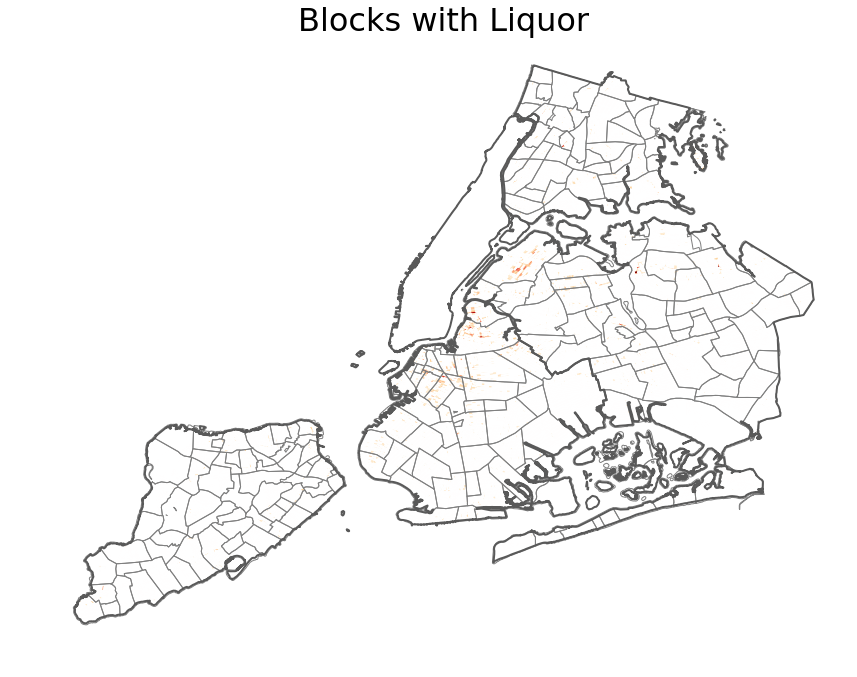

In [10]:
# turn liquor df into a geo-df
liquor_map = gpd.GeoDataFrame(liquor_df, crs=nyc_blk_map.crs)

# do a spatial join with bklyn blocks to remove points w/bad coords
liquor_map = gpd.tools.sjoin(liquor_map, nyc_blk_map, 
                                   how='right') # use left if you just want to plot points

# keep only columns of interest
liquor_map = liquor_map.drop(['index_left', 'Latitude', 'Longitude'], axis=1)

# set any present values to 1, else to 0
liquor_map['BarCount'] = 0
liquor_map.loc[~liquor_map.LicenseType.isnull(), 'BarCount'] = 1

# get a count of bars by block
liquor_map_agg = liquor_map.groupby('Block').agg({'BarCount': 
                                                   'sum'}).reset_index()
liquor_map_agg = pd.merge(liquor_map_agg, nyc_blk_map, how='left')
liquor_map_agg = liquor_map_agg.sort_index()
liquor_map_agg = gpd.GeoDataFrame(liquor_map_agg, crs=nyc_blk_map.crs)

# Remove blocks with unrealistically large areas
# via a robust sigma-clipping operation
liquor_map_agg['Area'] = liquor_map_agg.geometry.area
quartiles = np.percentile(liquor_map_agg['Area'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])
liquor_map_agg = liquor_map_agg.query('(Area < @mu + 5 * @sig)')


liquor_map_agg = pd.merge(nyc_blk_map, liquor_map_agg, left_on='Block', right_on='Block', how='outer')
sorter = nyc_blk_map.Block
liquor_map_agg.Block = liquor_map_agg.Block.astype("category")
liquor_map_agg.Block.cat.set_categories(sorter, inplace=True)
liquor_map_agg = liquor_map_agg.sort_values(['Block'])

vals = liquor_map_agg.BarCount.values
vals = np.nan_to_num(vals)

liq_vals = plot_by_block(vals, nyc_blk_map, 
                  nyc_nbhd_map, nyc_borough_map, "Blocks with Liquor",
                  'blocks_w_Liquor_vals', True, False)

# Map subway stations and turnstile data

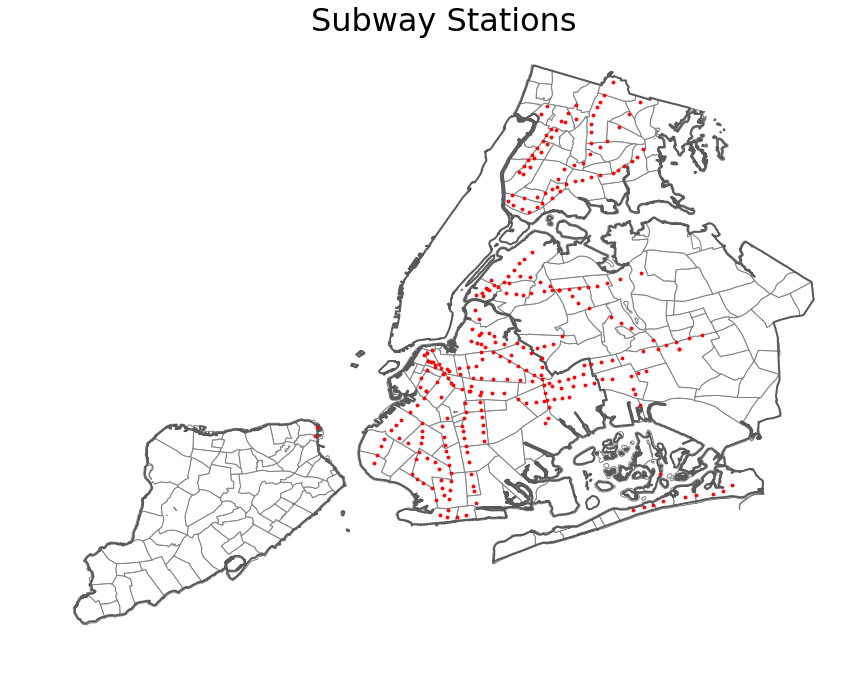

In [11]:
# Plot Subway Stations
fig, ax = plt.subplots(1, figsize=(x_size,y_size))
nyc_nbhd_map.plot(ax=ax, color='white', edgecolor='gray')
nyc_borough_map.plot(ax=ax, color='none', edgecolor='0.35', linewidth=2)
nyc_subway_trnstl_map.plot(ax=ax, marker="o", markersize=8, alpha=1, color='red')
ax.axis('off') # remove the axis
ax.set_title("Subway Stations", fontdict={'fontsize': '32', 'fontweight': '5'}) # add a title
fig.savefig(main_path + '/Results/Pics/Maps/subway_stations.png', dpi=500) 
plt.show()

In [12]:
# check dimensions
print(dist_mat.shape)
print(nyc_blk_map.shape)
print(nyc_subway_trnstl_map.shape)
print(nyc_blk_map.shape)

(34938, 304)
(34938, 3)
(304, 17)
(34938, 3)


# Model subway turnstile data

In [13]:
def get_vals_and_plot(vals_by_station, blk_to_station_dist, blk_map,
                          nbhd_map, borough_map, title, fn, to_norm):
    vals_by_station = vals_by_station.reshape(-1,1)
    zero_station_vals = np.isnan(vals_by_station)
    vals_by_station[zero_station_vals] = 0 # you need to set station & dist vals to 0 or will get incorporated
    blk_to_station_dist[:, np.squeeze(zero_station_vals)] = 0
    mat_sum = np.sum(blk_to_station_dist, axis=1).reshape(-1,1)
    zero_blk_vals = mat_sum == 0
    mat_sum[zero_blk_vals] = np.nan
    dot_prod = np.dot(blk_to_station_dist, vals_by_station)/mat_sum
    dot_prod = np.nan_to_num(dot_prod)
    if to_norm:
        dot_prod = (dot_prod - min(dot_prod)) * 10 / (max(dot_prod) - min(dot_prod)) # make vals go from 0-10
        print(max(dot_prod))
        print((min(dot_prod)))
    dot_prod[zero_blk_vals] = 0 # you need to reset these to 0 or will look like they have vals when other blks have negative vals
    blk_map_with_vals = blk_map.copy()
    blk_map_with_vals['vals'] = dot_prod
    blk_map_with_vals['zeros'] = dot_prod == 0 # to color 0 vals white
    zero_blk_map = blk_map_with_vals[blk_map_with_vals.zeros == True]

    # Remove blocks with unrealistically large areas (i.e. parks)
    # via a robust sigma-clipping operation
    quartiles = np.percentile(blk_map_with_vals['Area'], [25, 50, 75])
    mu = quartiles[1]
    sig = 0.74 * (quartiles[2] - quartiles[0])
    blk_map_with_vals[ blk_map_with_vals.Area > mu + 10 * sig ] = 0
    
    fig, ax = plt.subplots(1, figsize=(x_size, y_size))
    blk_map_with_vals.plot(ax=ax, column='vals', cmap='OrRd', vmin=0, vmax=10)  #  'autumn_r'
    zero_blk_map.plot(ax=ax, color='white', edgecolor='white') # so that 0 shows up white
    nbhd_map.plot(ax=ax, color='none', edgecolor='gray')
    borough_map.plot(ax=ax, color='none', edgecolor='0.35', linewidth=2)
    ax.axis('off') 
    ax.set_title(title, fontdict={'fontsize': '32', 'fontweight': '5'})
    fig.savefig(main_path + '/Results/Pics/Maps/' + fn + '.png', dpi=500) 
    plt.show()
    return blk_map_with_vals

[10.]
[0.]


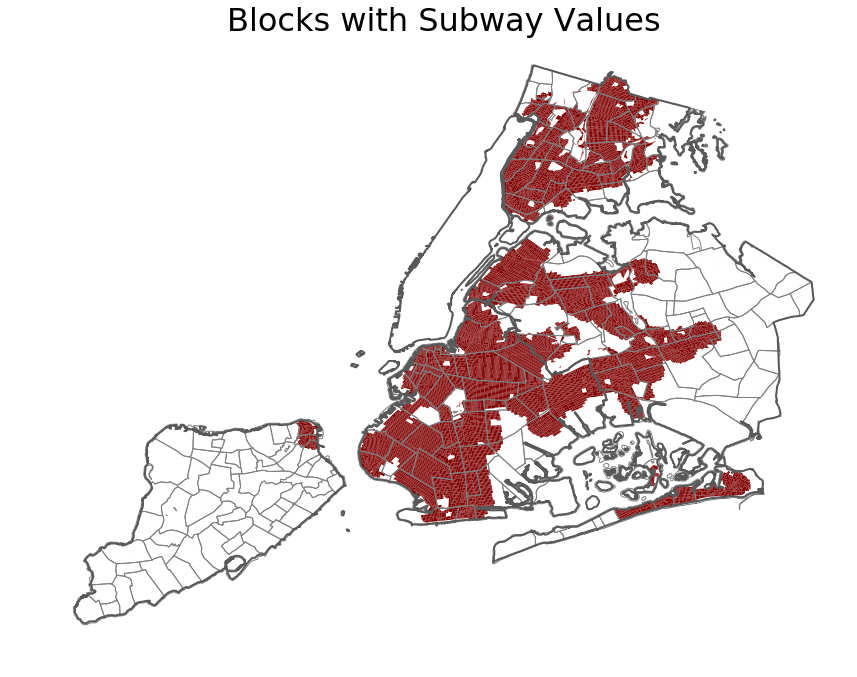

In [14]:
# check blocks
temp = get_vals_and_plot(np.ones(dist_mat.shape[1]), dist_mat, nyc_blk_map, 
                  nyc_nbhd_map, nyc_borough_map, "Blocks with Subway Values",
                  'blocks_w_subway_vals', True)

[10.]
[0.]


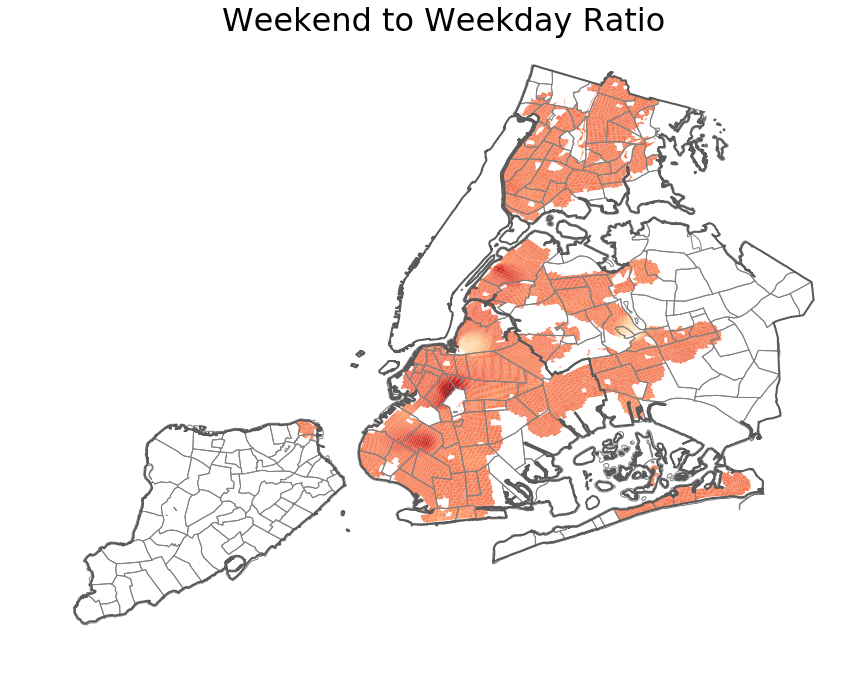

In [15]:
# simple check of weekend to weekday ratio
wkday = df_1_by_wkday_type.loc[(df_1_by_wkday_type.WK_DAY_TYPE == 1) & (df_1_by_wkday_type.TIME == 2), 'ENTRIES'].values
wknd = df_1_by_wkday_type.loc[(df_1_by_wkday_type.WK_DAY_TYPE == 2) & (df_1_by_wkday_type.TIME == 6), 'EXITS'].values + \
    df_1_by_wkday_type.loc[(df_1_by_wkday_type.WK_DAY_TYPE == 3) & (df_1_by_wkday_type.TIME == 6), 'EXITS'].values + \
    df_1_by_wkday_type.loc[(df_1_by_wkday_type.WK_DAY_TYPE == 3) & (df_1_by_wkday_type.TIME == 1), 'ENTRIES'].values + \
    df_1_by_wkday_type.loc[(df_1_by_wkday_type.WK_DAY_TYPE == 4) & (df_1_by_wkday_type.TIME == 1), 'ENTRIES'].values
ratio = wknd/wkday  

test = get_vals_and_plot(ratio, dist_mat, nyc_blk_map, 
                  nyc_nbhd_map, nyc_borough_map, "Weekend to Weekday Ratio",
                 'blocks_w_wknd_to_wkday_ratio', True)

#### ICA

In [16]:
run_ica = False

# Pull out entry and exit vectors
# REL update to be more elegant and use pandas

these_entries = df_1_by_wkday_type['ENTRIES']
these_exits = df_1_by_wkday_type['EXITS']
these_stations = df_1_by_wkday_type.groupby(['STATION']).count()['COUNT']

num_per_station = df_1_by_wkday_type.shape[0]/ these_stations.shape[0]
np.array(these_entries).reshape([304, 24])
these_entries = np.array(these_entries).reshape([int(these_stations.size), int(num_per_station)])
these_exits = np.array(these_exits).reshape([int(these_stations.size), int(num_per_station)])
these_entries_and_exits = np.hstack((these_entries, these_exits))
these_entries_and_exits_T = these_entries_and_exits.T
these_entries_and_exits_T = np.nan_to_num(these_entries_and_exits_T)
these_entries_T = these_entries.T
these_exits_T = these_exits.T

# Compute ICA on Bkyln

# perform ICA separately on exits and entries
# First set any station with a nan value anywhere to 0 everywhere
# This would probably be better if you removed them

num_comps = 4

# Entries
stations_w_nans1 = np.sum(np.isnan(these_entries_T),axis=0) != 0
these_entries_T[:, stations_w_nans1] = 0
if run_ica:
    ica1 = FastICA(num_comps)
    C1_ = ica1.fit_transform(these_entries_T)  # Reconstruct signals
    B1_ = ica1.mixing_  # Get estimated mixing matrix
    np.savetxt(main_path + '/Results/ica_components_entries.csv', C1_, delimiter=",")
    np.savetxt(main_path + '/Results/ica_weights_entries.csv', B1_, delimiter=",")
    
stations_w_nans2 = np.sum(np.isnan(these_exits_T),axis=0) != 0
these_exits_T[:, stations_w_nans2] = 0
if run_ica:
    ica2 = FastICA(num_comps)
    C2_ = ica2.fit_transform(these_exits_T)  # Reconstruct signals
    B2_ = ica2.mixing_  # Get estimated mixing matrix
    np.savetxt(main_path + '/Results/ica_components_exits.csv', C2_, delimiter=",")
    np.savetxt(main_path + '/Results/ica_weights_exits.csv', B2_, delimiter=",")

In [17]:
# load saved 
if not run_ica:
    C1_ = pd.read_csv(main_path + '/Results/ica_components_entries.csv', header=None).values
    B1_ = pd.read_csv(main_path + '/Results/ica_weights_entries.csv', header=None).values
    C2_ = pd.read_csv(main_path + '/Results/ica_components_exits.csv', header=None).values
    B2_ = pd.read_csv(main_path + '/Results/ica_weights_exits.csv', header=None).values

In [18]:
def plot_components(comp_vector, comp_num, is_entries):              
    
    font = {'family' : 'normal',
            'weight' : 'medium',
            'size'   : 16}
    matplotlib.rc('font', **font)
     
    dim = comp_vector.shape[0]
    if is_entries:
        entries = np.zeros(42)
        entries[0:6] = comp_vector[0:6]
        entries[6:12] = comp_vector[0:6]
        entries[12:18] = comp_vector[0:6]
        entries[18:] = comp_vector
        exits = np.zeros(42)
        suffix = 'entries'
        plot_name = 'Entries: ICA Component ' + str(comp_num)
    else:
        entries = np.zeros(42)
        exits = np.zeros(42)
        exits[0:6] = comp_vector[0:6]
        exits[6:12] = comp_vector[0:6]
        exits[12:18] = comp_vector[0:6]
        exits[18:] = comp_vector
        suffix = 'exits'
        plot_name = 'Exits: ICA Component ' + str(comp_num)
        
    comp_df = pd.DataFrame({'Entries': entries,
                            'Exits': exits})    
    fig, ax = plt.subplots(1, figsize=(12,5))
    matplotlib.pyplot.title(plot_name, fontsize=20, fontweight='heavy')

    comp_df.plot(ax=ax, marker='o')

    my_xticks = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
    plt.xticks([3, 9, 15, 21, 27, 35, 41], my_xticks)
    plt.xlim([0, 41])
    
    ax.vlines(0, -1, 1)
    ax.vlines(6, -1, 1)
    ax.vlines(12, -1, 1)
    ax.vlines(18, -1, 1)
    ax.vlines(24, -1, 1)
    ax.vlines(30, -1, 1)
    ax.vlines(36, -1, 1)
    
    ax.axes.set_ylim=[-1, 1] 
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Count (Standardized)', fontsize=20)

    plt.savefig(main_path + '/Results/Pics/ICA/' + suffix + '-component_num_' + str(comp_num) + '.png', dpi=300)
    plt.close()

for i in range(0, C1_.shape[1]):
    plot_components(C1_[:,i], i, True)

for i in range(0, C2_.shape[1]):
    plot_components(C2_[:,i], i, False)

/Users/rita/anaconda3/envs/insight/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/rita/anaconda3/envs/insight/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/rita/anaconda3/envs/insight/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


[[0.57078215 3.78309672 2.71580448 0.70792716]]
[[-0.14688663  2.83100016  3.77517814 -0.72589743]]


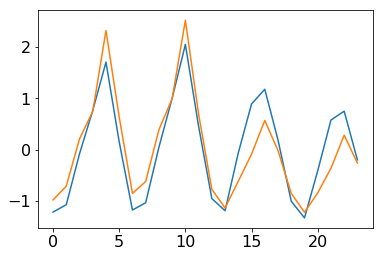

In [19]:
# check ICA of 2 places you know
wburg_idx = np.where(nyc_subway_trnstl_template.STATION == 'BEDFORD AV (L)')[0]
bay_idx = np.where(nyc_subway_trnstl_template.STATION == 'BAY RIDGE-95 ST (R)')[0]
remake = np.dot(C2_, B2_.T)
plt.plot(remake[:, wburg_idx])
plt.plot(remake[:, bay_idx])
print(B2_[wburg_idx,:])
print(B2_[bay_idx,:])

[10.]
[0.]


/Users/rita/anaconda3/envs/insight/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


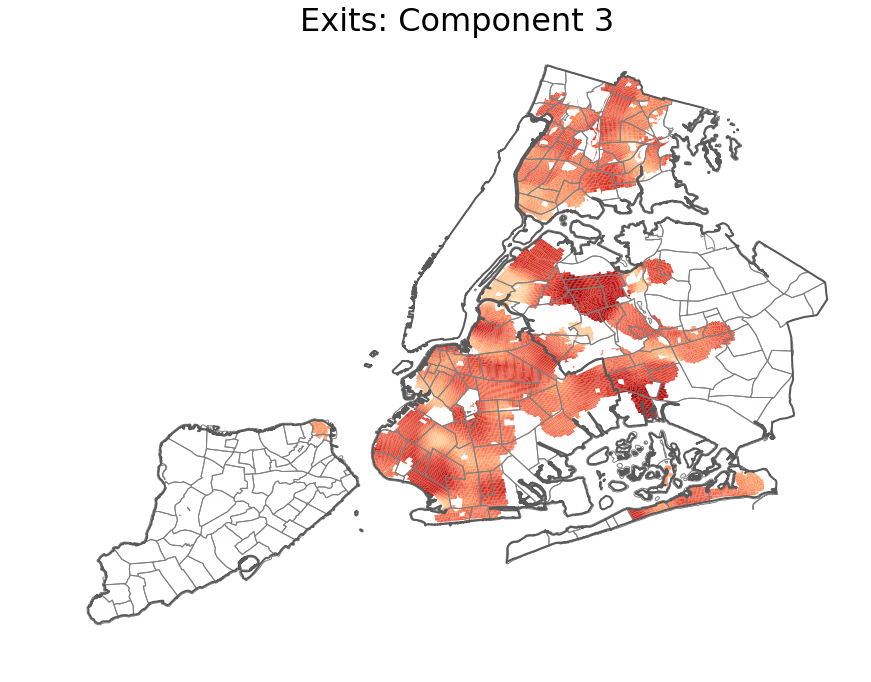

In [20]:
exits_comp_3 = get_vals_and_plot(B2_[:,3], dist_mat, nyc_blk_map, 
                  nyc_nbhd_map, nyc_borough_map, "Exits: Component 3",
                 'exits_comp_3', True)

[10.]
[0.]


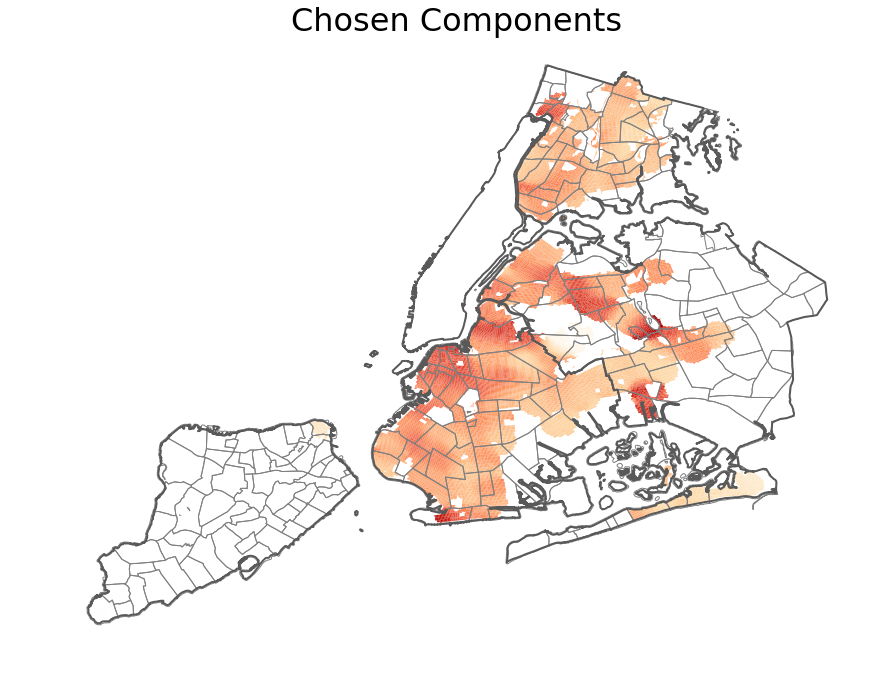

/Users/rita/anaconda3/envs/insight/lib/python3.7/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [21]:
comp_sum = B1_[:,0] + B1_[:,3] - B1_[:,1] - B1_[:,2] + B2_[:,0] + B2_[:,1] + B2_[:,3] - B2_[:,2] 
component_sum = get_vals_and_plot(comp_sum, dist_mat, nyc_blk_map, 
                  nyc_nbhd_map, nyc_borough_map, "Chosen Components",
                 'chosen_comps', True)
component_sum.to_file(main_path + '/Results/turnstile_vals_map.shp')
component_sum.to_csv(main_path + '/Results/turnstile_vals_map.csv')

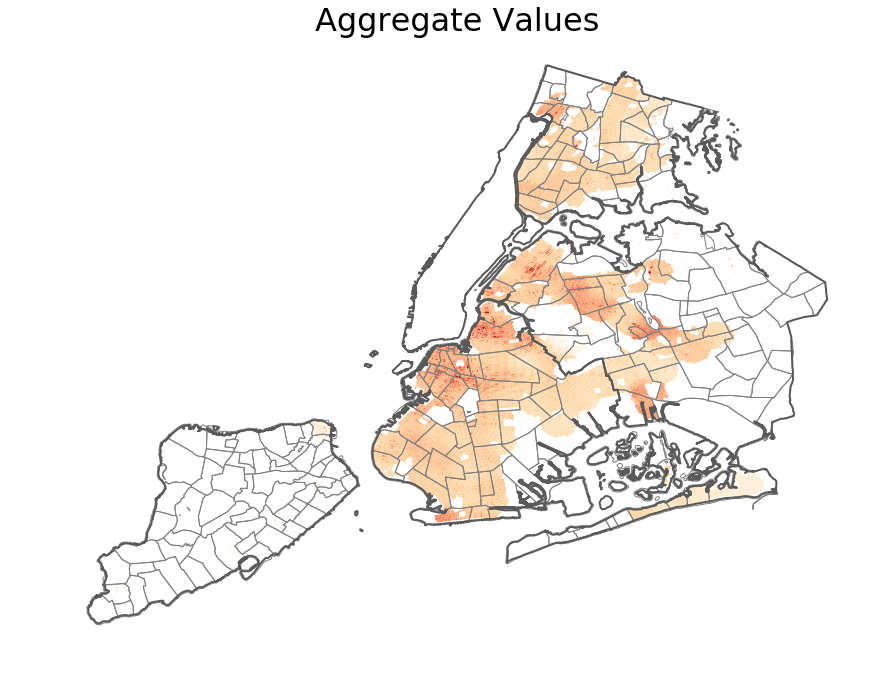

/Users/rita/anaconda3/envs/insight/lib/python3.7/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [22]:
# aggregate liquor and chosen components
agg_blocks = component_sum.copy()
agg_blocks.vals += liq_vals.vals

vals = agg_blocks.vals.values
agg_vals = plot_by_block(vals, nyc_blk_map, 
                  nyc_nbhd_map, nyc_borough_map, "Aggregate Values",
                  'aggregate_vals', True, False)

agg_vals.to_file(main_path + '/Results/agg_vals_map.shp')
agg_vals.to_csv(main_path + '/Results/agg_vals_map.csv')

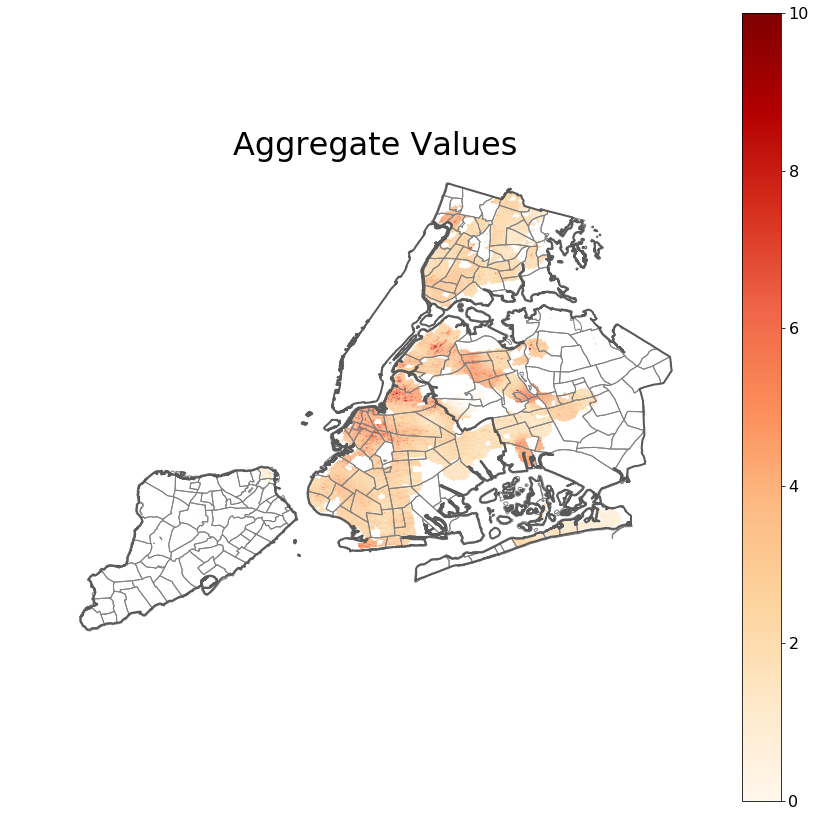

In [23]:
# Plot with cbar
temp = plot_by_block(vals, nyc_blk_map, 
                  nyc_nbhd_map, nyc_borough_map, "Aggregate Values",
                  'aggregate_vals_with_cbar', True, True)

(array([1.6582e+04, 1.7950e+03, 8.3310e+03, 5.0280e+03, 2.4070e+03,
        5.9100e+02, 1.3000e+02, 5.6000e+01, 9.0000e+00, 9.0000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

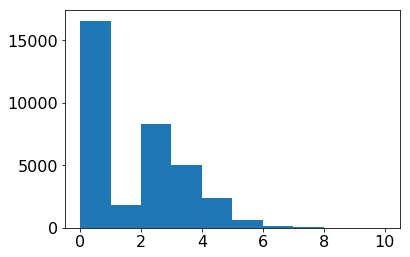

In [24]:
# check the distribution of aggregated values
plt.hist(agg_vals.vals)

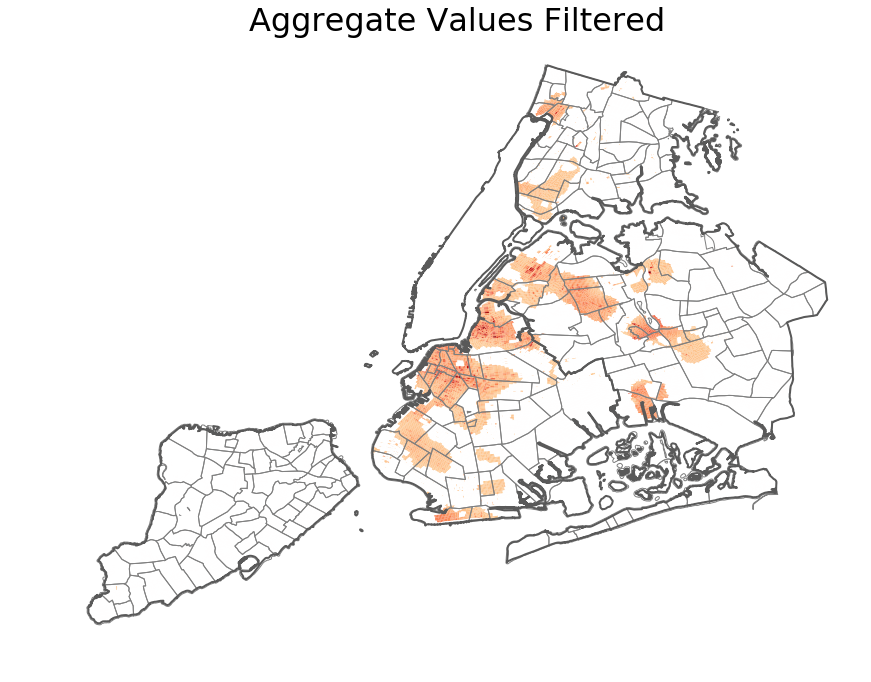

In [25]:
# Plot filtered vals (filter according to histogram)
# Don't normalize again
# Still goes from 0 to 10
agg_vals_filt = agg_vals.vals.copy()
agg_vals_filt[agg_vals_filt < 3] = 0
agg_vals_filt_df = plot_by_block(agg_vals_filt, nyc_blk_map, 
                  nyc_nbhd_map, nyc_borough_map, "Aggregate Values Filtered",
                  'aggregate_vals_filtered', False, False)

In [26]:
# Prep for Front-End

# attach filtered values to each block
nyc_blk_map['Vals'] = agg_vals_filt_df.vals

# get a neighborhood for each block
blocks_by_nbhd = gpd.tools.sjoin(nyc_blk_map, nyc_nbhd_map, how='left')
blocks_by_nbhd = blocks_by_nbhd[['Block', 'Neighborhood']].copy()
blocks_by_nbhd.at[blocks_by_nbhd.Neighborhood.isna(), 'Neighborhood'] = 'N/A' # don't use chained idx
blocks_by_nbhd = blocks_by_nbhd.groupby('Block')['Neighborhood'].apply(lambda x: '/'.join(x)).to_frame()
nyc_blk_map = pd.merge(nyc_blk_map, blocks_by_nbhd, on='Block', how='inner')

# Assign a label
nyc_blk_map.loc[(nyc_blk_map.Vals == 0), 'Rating'] = "Not"
nyc_blk_map.loc[(nyc_blk_map.Vals !=0)&(nyc_blk_map.Vals < 5), 'Rating'] = "Moderate"
nyc_blk_map.loc[nyc_blk_map.Vals >= 5, 'Rating'] = "Very"


In [27]:
# add info that you'll need for gmaps
nyc_blk_map = nyc_blk_map.drop(nyc_blk_map[nyc_blk_map.geometry.isna()].index)
nyc_blk_map['Centroid'] = nyc_blk_map.centroid
nyc_blk_map['latitude'] = [c.y for c in nyc_blk_map['Centroid']]
nyc_blk_map['longitude'] = [c.x for c in nyc_blk_map['Centroid']]
nyc_blk_map = nyc_blk_map.rename(columns={'Vals': 'magnitude'})
nyc_blk_map = nyc_blk_map.drop(['Centroid'], axis=1)

In [28]:
# save
nyc_blk_map.to_file(main_path + '/Results/nyc_blk_map_with_vals_for_front_end.shp')
nyc_blk_map.drop(['geometry'], axis = 1).to_csv(main_path + '/Results/nyc_blk_map_with_vals_for_front_end.csv')

# Remove any filtered values < 1 (i.e. original vals < 3)
nyc_blk_map = nyc_blk_map[nyc_blk_map.magnitude != 0]

# Remove blocks with unrealistically large areas (i.e. parks)
# via a robust sigma-clipping operation
quartiles = np.percentile(nyc_blk_map['Area'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])
nyc_blk_map[ nyc_blk_map.Area > mu + 10 * sig ] = 0

# save
nyc_blk_map.to_file(main_path + '/Results/nyc_blk_map_with_vals_for_front_end_FILTERED.shp')
nyc_blk_map.drop(['geometry', 'Block', 'Area','Neighborhood', 'Rating'], axis = 1).to_csv(main_path + 
                                    '/Results/nyc_blk_map_with_vals_for_front_end_FILTERED.csv')


/Users/rita/anaconda3/envs/insight/lib/python3.7/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
/Users/rita/anaconda3/envs/insight/lib/python3.7/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [30]:
nbhd_map = gpd.read_file(main_path + '/Results/nyc_nbhd_map.shp')

In [32]:
nbhd_map.crs

{'init': 'epsg:4326'}